In [1]:
%matplotlib inline
from vnpy.trader.vtObject import VtBarData
from vnpy.trader.vtConstant import EMPTY_STRING, EMPTY_FLOAT
from vnpy.trader.app.ctaStrategy.ctaBase import TICK_DB_NAME
from datetime import datetime, time
from vnpy.trader.app.ctaStrategy.ctaBacktesting import BacktestingEngine
from vnpy.trader.app.ctaStrategy.ctaTemplate import (CtaTemplate, 
                                                     BarManager, 
                                                     ArrayManager)

In [2]:
#合约代码
code = 'rb1805'
exchange = 'SHFE'
vtCode = '.'.join([code, exchange])
startDate = '20170106'

In [3]:
'''
我的策略
'''
class SimpleStrategy(CtaTemplate):
    """根据夜盘收盘前的价格趋势开仓入场，移动百分比离场"""
    className = 'SimpleStrategy'
    author = u'loe'

    # 策略参数
    tradeSize = 1 # 交易数量
    startTime = time(22, 58, 26) # 趋势判断开始时间
    endTime =  time(22, 59, 56) # 趋势判断截至时间
    outPercent = 0.1 # 移动止盈止损百分比

    # 策略变量
    todayDate = None # 当前日期
    todayEntry = False # 当天是否已经产生信号
    startPrice = EMPTY_FLOAT # 趋势判断开始价格
    endPrice = EMPTY_FLOAT # 趋势判断截至价格
    highPrice = EMPTY_FLOAT # 持仓后的最高价，为了多头止盈止损的计算
    lowPrice = EMPTY_FLOAT # 持仓后的最低价， 为了空头止盈止损的计算

    # 参数列表，保存了参数的名称
    paramList = ['name',
                 'className',
                 'author',
                 'vtSymbol',
                 'tradeSize',
                 'startTime',
                 'endTime',
                 'outPercent']    

    # 变量列表，保存了变量的名称
    varList = ['inited',
               'trading',
               'pos',
               'todayDate',
               'todayEntry',
               'startPrice',
               'endPrice',
               'highPrice',
               'lowPrice']
    
    # 同步列表
    syncList = ['pos',
                'highPrice',
                'lowPrice']
    
    #测试------
    entryPrice = EMPTY_FLOAT
    outPrice = EMPTY_FLOAT
    totalEarning = EMPTY_FLOAT
    

    #----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        """Constructor"""
        super(SimpleStrategy, self).__init__(ctaEngine, setting)        

    #----------------------------------------------------------------------
    def onInit(self):
        """初始化策略（必须由用户继承实现）"""
        self.writeCtaLog(u'%s策略初始化' %self.name)
        self.putEvent()

    #----------------------------------------------------------------------
    def onStart(self):
        """启动策略（必须由用户继承实现）"""
        self.writeCtaLog(u'%s策略启动' %self.name)
        self.putEvent()

    #----------------------------------------------------------------------
    def onStop(self):
        """停止策略（必须由用户继承实现）"""
        self.writeCtaLog(u'%s策略停止' %self.name)
        self.putEvent()

    #----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送（必须由用户继承实现）"""
        #print tick.datetime, ' '*2, tick.lastPrice
        
        #撤销未成交的单
        self.cancelAll()
        
        if (not self.todayDate) or (self.todayDate != tick.datetime.date()):
            # 早盘第一个tick收到后信号初始化
            #print tick.datetime, '='*16
            self.todayDate = tick.datetime.date()
            self.todayEntry = False
            self.startPrice = EMPTY_FLOAT
            self.endPrice = EMPTY_FLOAT
        
        if self.pos == 0:
            self.highPrice = EMPTY_FLOAT
            self.lowPrice = EMPTY_FLOAT
            # 当前仓位为空才会做新的开仓信号判断
            if (self.startPrice == 0) and (tick.datetime.time() >= self.startTime) and (tick.datetime.time() < self.endTime):
                self.startPrice = tick.lastPrice
            
            if (self.endPrice == 0) and (tick.datetime.time() >= self.endTime):
                self.endPrice = tick.lastPrice
            
            if self.startPrice and self.endPrice and (not self.todayEntry):
                sub = self.endPrice - self.startPrice
                if sub > 0:
                    # 开仓多头
                    self.buy(tick.lastPrice + 10, self.tradeSize) # 限价单
                    #print u'委托多头开仓', tick.datetime, '*'*2, tick.lastPrice
                elif sub < 0:
                    # 开仓空头
                    self.short(tick.lastPrice - 10, self.tradeSize) # 限价单
                    #print u'委托空头开仓', tick.datetime, '*'*2, tick.lastPrice
        elif self.pos > 0:
            # 持有多头仓位
            '''
            print '='*20, tick.datetime, '='*20
            print 'tickPrice', '*'*2, tick.lastPrice
            print 'highPrice', '*'*2, self.highPrice
            '''
            if tick.lastPrice <= self.highPrice * (1 - self.outPercent/100):
                #止盈止损
                self.sell(tick.lastPrice -10, abs(self.pos)) # 限价单
                #print u'止损'
        elif self.pos < 0:
            # 持有空头仓位
            '''
            print '='*20, tick.datetime, '='*20
            print 'tickPrice', '*'*2, tick.lastPrice
            print 'lowPrice', '*'*2, self.lowPrice
            '''
            if tick.lastPrice >= self.lowPrice * (1 + self.outPercent/100):
                #止盈止损
                self.cover(tick.lastPrice +10, abs(self.pos)) # 限价单
                #print u'止损'
                
        if self.pos:
            self.highPrice = max(self.highPrice, tick.lastPrice)
            self.lowPrice = min(self.lowPrice, tick.lastPrice)

        # 发出状态更新事件
        self.putEvent()

    #----------------------------------------------------------------------
    def onBar(self, bar):
        """收到Bar推送（必须由用户继承实现）"""
        # 发出状态更新事件
        self.putEvent()

    #----------------------------------------------------------------------
    def onOrder(self, order):
        """收到委托变化推送（必须由用户继承实现）"""
        pass

    #----------------------------------------------------------------------
    def onTrade(self, trade):
        # 发出状态更新事件
        self.putEvent()
        if trade.offset == u'开仓':
            self.todayEntry = True
            self.highPrice = trade.price
            self.lowPrice = trade.price
        '''
        print '#'*20, 'T R A D E', '#'*20
        print trade.tradeTime
        print trade.direction
        print trade.offset
        print trade.price
        print self.pos, '\n'
        '''
        
        #测试------
        if trade.offset == u'开仓':
            self.entryPrice = trade.price
        elif trade.offset == u'平仓':
            self.outPrice = trade.price
            '''
            print u'开仓价======', self.entryPrice
            print u'平仓价======', self.outPrice
            '''
            sub = self.outPrice - self.entryPrice
            if trade.direction == u'多':
                self.totalEarning -= sub
                '''
                print '='*6, u'盈亏 ', -sub, '='*6
                print '='*6, u'累计盈亏 ', self.totalEarning, '='*6
                '''
            else:
                self.totalEarning += sub
                '''
                print '='*6, u'盈亏 ', sub, '='*6
                print '='*6, u'累计盈亏 ', self.totalEarning, '='*6
                '''
            
            #print '\n'
            

    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass

2018-01-11 22:43:49.109000	开始载入数据
2018-01-11 22:43:51.820000	载入完成，数据量：3715088
2018-01-11 22:43:51.820000	开始回测
2018-01-11 22:43:51.822000	策略初始化完成
2018-01-11 22:43:51.823000	策略启动完成
2018-01-11 22:43:51.825000	开始回放数据
2018-01-11 22:47:44.154000	数据回放结束
2018-01-11 22:47:44.155000	计算按日统计结果
2018-01-11 22:47:44.229000	------------------------------
2018-01-11 22:47:44.229000	首个交易日：	2017-05-15
2018-01-11 22:47:44.230000	最后交易日：	2018-01-10
2018-01-11 22:47:44.230000	总交易日：	195
2018-01-11 22:47:44.230000	盈利交易日	68
2018-01-11 22:47:44.230000	亏损交易日：	87
2018-01-11 22:47:44.230000	起始资金：	6000
2018-01-11 22:47:44.230000	结束资金：	10,015.87
2018-01-11 22:47:44.230000	总收益率：	66.93
2018-01-11 22:47:44.232000	总盈亏：	4,015.87
2018-01-11 22:47:44.232000	最大回撤: 	-635.5
2018-01-11 22:47:44.232000	总手续费：	874.13
2018-01-11 22:47:44.232000	总滑点：	0.0
2018-01-11 22:47:44.232000	总成交金额：	8,741,330.0
2018-01-11 22:47:44.232000	总成交笔数：	244.0
2018-01-11 22:47:44.232000	日均盈亏：	20.59
2018-01-11 22:47:44.232000	日均手续费：	4.48
2018-01-11 22:47:

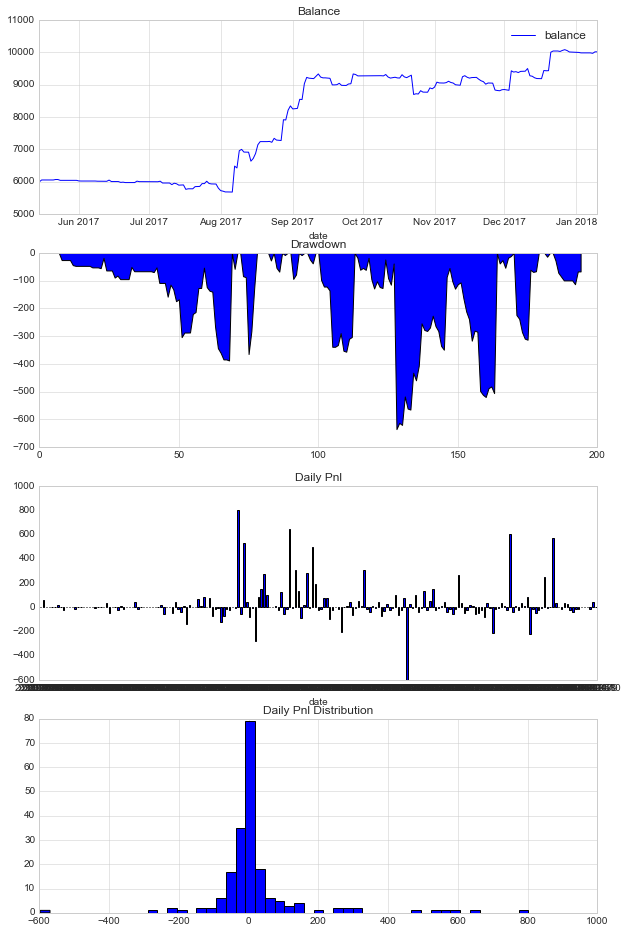

In [5]:
'''
回测
'''

#创建回测引擎实例
engine = BacktestingEngine()

#设置引擎的回测模式为K线
engine.setBacktestingMode(engine.TICK_MODE)

#设置回测的起始日期
engine.setStartDate(startDate, initDays = 0)

#设置产品相关参数
engine.setSlippage(0)           #滑点设置为0
engine.setRate(1.0/10000)       #合约交易手续费万1
engine.setSize(10)               #合约每手数量
engine.setPriceTick(1)      #合约最小价格变动
engine.setCapital(6000) #初始资金

#设置使用的数据库
engine.setDatabase(TICK_DB_NAME, vtCode)

#引擎中创建策略对象
engine.initStrategy(SimpleStrategy, {})

#开始跑回测
engine.runBacktesting()

#显示回测结果
engine.showDailyResult()